# Ejercicio: Servicio de alquiler de bicicletas públicas de Sevilla (Sevici)
**Autor**: Mariano González.      **Revisores**: Carlos G. Vallejo, José A. Troyano, Fermín Cruz.     **Última modificación:** 08/11/2018

En este ejercicio vamos a trabajar con la red de estaciones del servicio de alquiler de bicicletas de Sevilla, Sevici. Para ello disponemos de los datos de las estaciones, obtenidos de https://citybik.es/.

En primer lugar leeremos los datos de las estaciones desde un fichero CSV. Realizaremos algunas operaciones con los datos, como obtener las estaciones con bicicletas libres o las estaciones más próximas a nuestra ubicación. Finalmente, dibujaremos sobre el mapa las estaciones, distinguiendo entre las que tienen bicicletas disponibles y las que no las tienen.

Las funciones que vamos a desarrollar son las siguientes:

1. lee_estaciones: lee los datos de las estaciones desde un fichero csv
2. estaciones_bicis_libres: crea una lista con las estaciones que tienen bicicletas libres, ordenada por el número de bicis libres
3. calcula_distancia: calcular la distancia a una estación desde un punto dado
4. estaciones_cercanas: crea una lista con las estaciones con bicis libres más cercanas a un punto dado, ordenadas de la más cercana a la más lejana
5. ubicacion_estaciones: crear una lista con las coordenadas de todas las estaciones
6. ubicacion_estaciones_libres: crear una lista con las coordenadas de todas las estaciones que tienen bicicletas libres

## 1. Carga de datos
Se dispone de los datos de las estaciones de la red de Sevici. Los datos se encuentran en un fichero CSV. Cada línea del fichero contiene seis datos:

    Nombre de la estación
    Número total de bornetas de la estación
    Número de bornetas vacías
    Número de bicicletas disponibles
    Latitud
    Longitud

Los datos dependen del instante en que se obtiene el fichero, ya que el número de bicicletas y bornetas libres varía de forma continua. Estan serían, por ejemplo, las primeras líneas del fichero en un momento dado:

        name,slots,empty_slots,free_bikes,latitude,longitude
        149_CALLE ARROYO,20,11,9,37.397829929383,-5.97567172039552
        257_TORRES ALBARRACIN,20,16,4,37.38376948792722,-5.908921914235877
        243_GLORIETA DEL PRIMERO DE MAYO,15,6,9,37.380439481169994,-5.953481197462845
        109_AVENIDA SAN FRANCISCO JAVIER,15,1,14,37.37988413609134,-5.974382770011586
        073_PLAZA SAN AGUSTIN,15,10,4,37.38951386231434,-5.984362789545622

Los principales aspectos que tendremos que resolver a la hora de procesar estos datos de entrada serán saltar la línea de encabezado del fichero, separar adecuadamente los campos mediante las comas e interpretar el formato de cada uno de los campos, que puede ser de tipo cadena, entero o real.

Para resolver estos problemas haremos uso de algunas utilidades disponibles en la librería estándar de Python. En concreto, antes de empezar, deberemos importar los siguientes elementos:

In [1]:
import csv
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from collections import namedtuple
from typing import NamedTuple, List, Tuple

### 1.1 Función de lectura de datos

La siguiente función será la encargada de leer el fichero con las estaciones y construir a partir de él una estructura de datos en memoria.

In [3]:
# Creación de un tipo de namedtuple para las estaciones
Estacion = NamedTuple('Estacion', [('nombre',str),('bornetas',int),('bornetas_vacias',int), ('bicis_disponibles',int),('latitud',float),('longitud',float)])

# Función de lectura que crea una lista de Estaciones
def lee_estaciones(fichero:str)->List[Estacion]:
   registros = []
   with open ('./data/estaciones.csv', encoding='utf-8') as f:
      lector = csv.reader(f)
      next(lector)
      for nombre,bornetas,bornetas_vacias,bicis_disponibles,latitud,longitud in lector:
         tupla=Estacion(nombre=str(nombre),
         bornetas=int(bornetas),
         bornetas_vacias=int(bornetas_vacias),
         bicis_disponibles=int(bicis_disponibles),
         latitud=float(latitud),
         longitud=float(longitud))
         registros.append(tupla)
      return registros   
   ''' Lee el fichero de datos y devuelve una lista de estaciones
    
    ENTRADA: 
       - fichero: nombre del fichero CSV -> str
    SALIDA: 
       - lista de estaciones -> [Estacion(str, int, int, int, float, float)] 
    
    Cada estación se representa con una tupla con los siguientes valores:
    - Nombre de la estación
    - Número total de bornetas
    - Número de bornetas vacías
    - Número de bicicletas disponibles
    - Latitud
    - Longitud
    Usaremos el módulo csv de la librería estándar de Python para leer el
    fichero de entrada.
    Hay que saltar la línea de encabezado del fichero y comenzar a leer los datos
    a partir de la segunda línea.
    Hay que realizar un pequeño procesamiento con los datos numéricos. Hay que
    pasar del formato cadena (que es lo que se interpreta al leer el csv) a un
    valor numérico (para poder aplicar operaciones matemáticas si fuese necesario).
    '''
   

In [4]:
# Test de la función lee_estaciones
estaciones_sevici = lee_estaciones('./data/estaciones.csv')
for estacion in estaciones_sevici[:5]:
    print(estacion)

Estacion(nombre='149_CALLE ARROYO', bornetas=20, bornetas_vacias=11, bicis_disponibles=9, latitud=37.397829929383, longitud=-5.97567172039552)
Estacion(nombre='257_TORRES ALBARRACIN', bornetas=20, bornetas_vacias=16, bicis_disponibles=4, latitud=37.38376948792722, longitud=-5.908921914235877)
Estacion(nombre='243_GLORIETA DEL PRIMERO DE MAYO', bornetas=15, bornetas_vacias=6, bicis_disponibles=9, latitud=37.380439481169994, longitud=-5.953481197462845)
Estacion(nombre='109_AVENIDA SAN FRANCISCO JAVIER', bornetas=15, bornetas_vacias=1, bicis_disponibles=14, latitud=37.37988413609134, longitud=-5.974382770011586)
Estacion(nombre='073_PLAZA SAN AGUSTIN', bornetas=15, bornetas_vacias=10, bicis_disponibles=4, latitud=37.38951386231434, longitud=-5.984362789545622)


## 2. Operaciones de consulta

En esta sección veremos una serie de funciones que nos permitirán filtrar y extraer informaciones de la estructura de datos que estamos manejando para representar las estaciones (una lista de tuplas). Utilizaremos estas funciones de _consulta_ en distintos puntos del resto del ejercicio.

### 2.1 Estaciones con bicicletas libres

La primera función de este tipo creará una lista con las estaciones que tienen un número de bicicletas libres superior a un valor dado, que por defecto es 5. La lista de salida estará formada por tuplas con dos elementos, el número de bicicletas libres y el nombre de la estación, y estará ordenada por el número de bicicletas libres

In [5]:

def estaciones_bicis_libres(estaciones:List[Estacion], k:int=5)->List[Tuple[int,str]]:
   lista_libres=[]
   for estacion in estaciones:
      if estacion.bicis_disponibles > k:
         tupla=(estacion.bicis_disponibles,estacion.nombre)
         lista_libres.append(tupla)
         lista_libres.sort(reverse=True)
   return lista_libres
     
      
   
   ''' Estaciones que tienen bicicletas libres
    
    ENTRADA: 
       - estaciones: lista de estaciones disponibles -> [Estacion(str, int, int, int, float, float)]
       - k: número mínimo requerido de bicicletas -> int
    SALIDA: 
       - lista de estaciones seleccionadas -> [(int, str)] 
    
    Toma como entrada una lista de estaciones y un número k.
    Crea una lista formada por tuplas (número de bicicletas libres, nombre)
    de las estaciones que tienen al menos k bicicletas libres. La lista
    estará ordenada por el número de bicicletas libres.
    '''
    

In [6]:
# Test de la función estaciones_bicis_libres
libres3 = estaciones_bicis_libres(estaciones_sevici, 1)
print("Hay", len(libres3), "estaciones con al menos una bici libre:", libres3[:5])
libres1 = estaciones_bicis_libres(estaciones_sevici)
print("Hay", len(libres1), "estaciones al menos 5 bicis libres:", libres1[:5])
libres2 = estaciones_bicis_libres(estaciones_sevici, 10)
print("Hay", len(libres2), "estaciones con al menos 10 libres:", libres2[:5])


Hay 203 estaciones con al menos una bici libre: [(39, '005_CAMINO DE LOS DESCUBRIMIENTOS'), (35, '087_PLAZA NUEVA'), (30, '098_AVENIDA DE ROMA'), (29, '247_AVDA. RAMON Y CAJAL'), (29, '004_CALLE LEONARDO DA VINCI')]
Hay 129 estaciones al menos 5 bicis libres: [(39, '005_CAMINO DE LOS DESCUBRIMIENTOS'), (35, '087_PLAZA NUEVA'), (30, '098_AVENIDA DE ROMA'), (29, '247_AVDA. RAMON Y CAJAL'), (29, '004_CALLE LEONARDO DA VINCI')]
Hay 74 estaciones con al menos 10 libres: [(39, '005_CAMINO DE LOS DESCUBRIMIENTOS'), (35, '087_PLAZA NUEVA'), (30, '098_AVENIDA DE ROMA'), (29, '247_AVDA. RAMON Y CAJAL'), (29, '004_CALLE LEONARDO DA VINCI')]


### 2.2 Estaciones cercanas a una ubicación

La segunda función de consulta creará una lista con las estaciones más próximas a un punto dado que tengan bicicletas libres.

En primer lugar vamos a escribir una función que calcule la distancia entre dos puntos dados por su latitud y longitud. Esta función nos permitirá calcular la distancia entre un punto (nuestra ubicación, por ejemplo) y las estaciones cercanas. Utilizaremos la distancia euclídea con una pequeña modificación para tener en cuenta el número de bicicletas libres que hay en la estación. El motivo es el siguiente: si tenemos dos estaciones a una distancia similar, lo más lógico es elegir aquella que tenga más bicicletas libres, ya que será más probable que encontremos una bicicleta cuando lleguemos a la estación.

La fórmula que usaremos para calcular la distancia entre una ubicación dada por las coordenadas $(x, y)$ y una estación dada por las coordenadas $(xe, ye)$ que tiene $fb$ bicicletas libres será la siguiente:

$$
distancia = \sqrt {(xe-x)^2 + (ye-y)^2} * (1 - \frac{fb}{100})
$$

In [9]:
import math
def calcula_distancia(x1:float, y1:float, x2:float, y2:float, fb:int)->float:
   distancia = math.sqrt((( x2 - x1 ) ** 2 + ( y2 - y1 )** 2 )* ( 1 - fb / 100 ))
   return distancia
   ''' Distancia entre un punto y una estación
    
    ENTRADA: 
       - x1: latitud del primer punto -> float
       - y1: longitud del primer punto -> float
       - x2: latitud del segundo punto -> float
       - y2: longitud del segundo punto -> float
       - fb: número de bicicletas libres -> int
    SALIDA: 
       - distancia entre un punto y una estación -> float 
    
    Toma como entrada la latitud y longitud de un punto, la longitud y
    latitud de una estación y el número de bicicletas libres de la estación.
    Calcula la distancia entre el punto y la estación aplicando la fórmula
    
        distancia = sqrt((x2-x1)**2 + (y2-y1)**2) * (1 - fb/100)
    '''
    

Ahora vamos a escribir la función que calcula las estaciones más cercanas a una ubicación dada y que tienen bicicletas libres, utilizando la función anterior para calcular la distancia desde la ubicación hasta cada estación.

La función recibe la lista de estaciones, las coordenadas de la ubicación y un número k, y crea una lista con las k estaciones más cercanas a la ubicación, ordenadas de menor a mayor distancia. La lista resultante está formada por tuplas con tres elementos: la distancia a la ubicación, el nombre de la estación y el número de bicicletas libres de la estación.

In [10]:

def estaciones_cercanas(estaciones:List[Estacion], latitud:float, longitud:float, k:int=5)->List[Tuple[float,str,int]]:
    lista_distancias=[]
    for estacion in estaciones:
       if estacion.bicis_disponibles > k:
          distancia = calcula_distancia(latitud,longitud,estacion.latitud,estacion.longitud,estacion.bicis_disponibles)
          lista_distancias.append((distancia,estacion.nombre,estacion.bicis_disponibles))
          lista_distancias = sorted(lista_distancias)
    return lista_distancias
''' Estaciones cercanas a un punto dado
    
    ENTRADA: 
       - estaciones: lista de estaciones disponibles -> [Estacion(str, int, int, int, float, float)]
       - latitud: latitud del punto -> float
       - longitud: longitud del punto -> float
       - k: número de estaciones cercanas a calcular -> int
    SALIDA: 
       - distancia, nombre y bicicletas libres de las estaciones seleccionadas -> [(float, str, int)] 
    
    Toma como entrada una lista de estaciones, la latitud y longitud de un punto y
    un valor k.
    Crea una lista formada por tuplas (distancia, nombre de estación, bicicletas libres)
    con las k estaciones con bicicletas libres más cercanas al punto dado, ordenada por
    su distancia al punto.
    '''
    

' Estaciones cercanas a un punto dado\n    \n    ENTRADA: \n       - estaciones: lista de estaciones disponibles -> [Estacion(str, int, int, int, float, float)]\n       - latitud: latitud del punto -> float\n       - longitud: longitud del punto -> float\n       - k: número de estaciones cercanas a calcular -> int\n    SALIDA: \n       - distancia, nombre y bicicletas libres de las estaciones seleccionadas -> [(float, str, int)] \n    \n    Toma como entrada una lista de estaciones, la latitud y longitud de un punto y\n    un valor k.\n    Crea una lista formada por tuplas (distancia, nombre de estación, bicicletas libres)\n    con las k estaciones con bicicletas libres más cercanas al punto dado, ordenada por\n    su distancia al punto.\n    '

In [11]:
# Test de la función
cerca_de_mi = estaciones_cercanas(estaciones_sevici, 37.357659, -5.9863)
for estacion in cerca_de_mi[:15]:
    print(estacion)

(0.0005016670271839663, '126_AVENIDA REINA MERCEDES', 13)
(0.0012709432385177917, '040_AVENIDA REINA MERCEDES', 7)
(0.002316362901662685, '146_AVENIDA REINA MERCEDES', 10)
(0.0023593789090751967, '145_AVENIDA REINA MERCEDES', 16)
(0.004366143085096041, '207_CALLE IFNI', 15)
(0.0046007696284608, '153_AVENIDA REINA MERCEDES', 25)
(0.005454589235767312, '116_CALLE MANUEL SIUROT', 18)
(0.005500606491315289, '132_CALLE PAEZ DE RIVERA', 20)
(0.005517601953250936, '105_CALLE FRANCISCO MURILLO', 10)
(0.006634810011065495, '114_GLORIETA PLUS ULTRA', 14)
(0.006821678224957362, '208_AVENIDA DE GRECIA', 13)
(0.00777864032633226, '131_CALLE TABLADILLA', 18)
(0.009314243586570464, '028_CALLE RAFAEL SALGADO', 13)
(0.009495972227265663, '159_AVENIDA CARDENAL BUENO MONREAL', 18)
(0.009701718152447107, '212_AVENIDA REINIDO UNIDO', 14)


## 3. Visualización de estaciones

Vamos a visualizar gráficamente algunos resultados. Para ello dibujaremos un mapa y sobre él marcaremos las estaciones que cumplan algunos requisitos, como por ejemplo tener un número mínimo de bicicletas libres.

Ejecuta en primer lugar las dos siguientes funciones. La primera carga una imagen y la coloca como fondo del gráfico. La segunda muestra un conjunto de puntos que representan estaciones en la red. En las funciones que escribiremos más adelante llamaremos a estas funciones para crear el mapa y dibujar sobre él las estaciones.

In [12]:
def dibuja_mapa()->None:
    ancho = 9
    aspect_ratio = 1.09
    img = mpimg.imread('./img/mapa.png')
    plt.figure(figsize=(ancho, ancho * aspect_ratio))
    plt.imshow(img, zorder=0, extent=[0, ancho, 0, ancho * aspect_ratio])    
    plt.axis('off')    

In [13]:
def dibuja_estaciones(coordenadas:List[Tuple[float,float]], color:str="red")->None:
    ancho = 9
    aspect_ratio = 1.09
    xs = [(x - 37.31) * ancho * aspect_ratio / 0.13 for x, _ in coordenadas]
    ys = [(y + 6.04) * ancho / 0.15 for _, y in coordenadas]
    plt.scatter(ys, xs, zorder=1, s=10, color=color)

### 3.1 Mostrar todas las estaciones

En primer lugar vamos a mostrar sobre el mapa todas las estaciones de la red. Para ello crearemos una lista con las coordenadas (latitud y longitud) de todas las estaciones de la red.

In [15]:
def ubicacion_estaciones(estaciones:List[Estacion] )->List[Tuple[float,float]]:
   lista_coordenadas = []
   for estacion in estaciones:
      lista_coordenadas.append((estacion.latitud,estacion.longitud))
   return lista_coordenadas
      
   ''' Coordenadas de todas las estaciones
    
    ENTRADA: 
       - estaciones: lista de estaciones disponibles -> [Estacion(str, int, int, int, float, float)]
    SALIDA: 
       - latitudes y longitudes de las estaciones -> [(float, float)] 
    
    Recibe un lista de estaciones.
    Crea una lista formada por tuplas (latitud, longitud) con todas las estaciones.
    '''
    

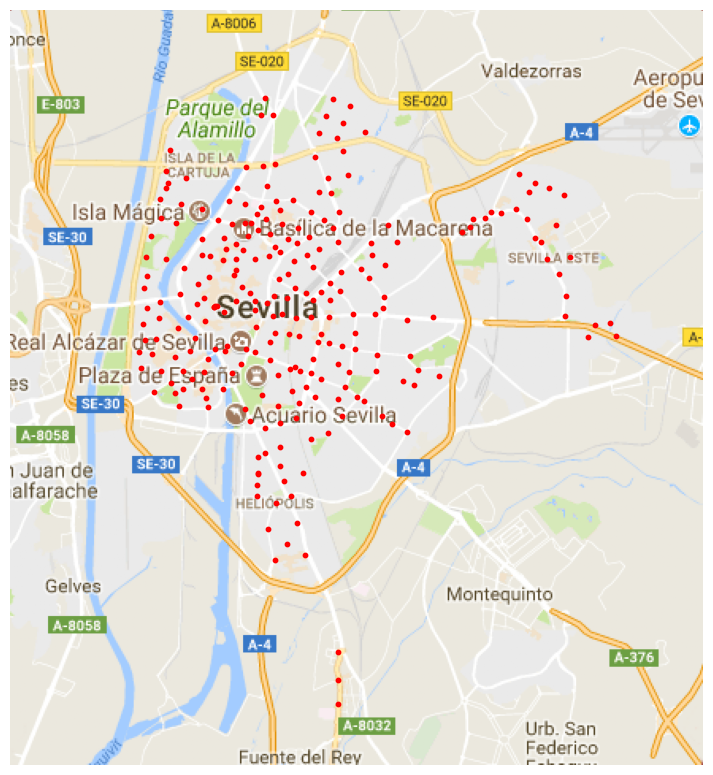

In [16]:
# Test de la función ubicacion_estaciones
coordenadas = ubicacion_estaciones(estaciones_sevici)
dibuja_mapa()
dibuja_estaciones(coordenadas)
plt.show()

### 3.2 Mostrar todas las estaciones indicando si tienen o no bicis libres

En segundo lugar vamos a mostrar en el mapa todas las estaciones, pero distinguiendo entre las que tienen bicicletas libres, que aparecerán en color verde, y las que no tienen bicicletas libres, que aparecerán en color rojo.

Ya tenemos la función que calcula las coordenadas de todas las estaciones. Vamos a escribir ahora una nueva función que calcule las coordenadas de todas las estaciones que tienen un número mínimo de bicicletas libres. Este número será un parámetro de la función, y tendrá un valor por defecto que será 5.

In [23]:
def ubicacion_estaciones_libres(estaciones:List[Estacion], k:int=5)->List[Tuple[float,float]]:
   lista_coordenadas_libres=[]
   for estacion in estaciones:
      if estacion.bicis_disponibles > k:
         lista_coordenadas_libres.append((estacion.latitud,estacion.longitud))
   return lista_coordenadas_libres 
   ''' Coordenadas de las estaciones con bicicletas libres
    
    ENTRADA: 
       - estaciones: lista de estaciones disponibles -> [Estacion(str, int, int, int, float, float)]
       - k: número mínimo requerido de bicicletas libres -> int
    SALIDA: 
       - latitudes y longitudes de las estaciones seleccionadas -> [(float, float)] 
    
    Recibe una lista de estaciones y un valor k.
    Crea una lista formada por tuplas (latitud, longitud) con todas las estaciones
    que tienen al menos k bicicletas libres.
    '''
    

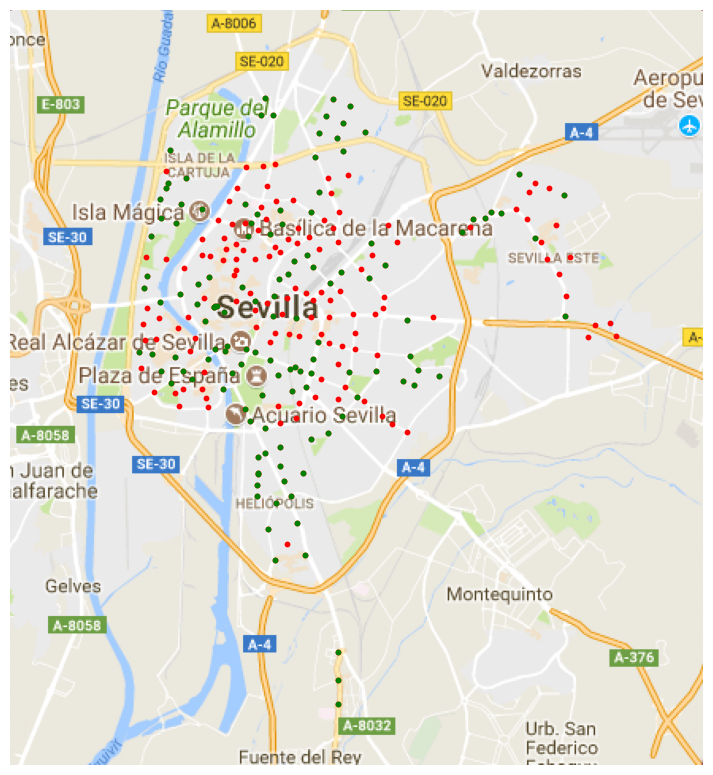

In [24]:
# Test de la función ubicacion_estaciones_libres
coordenadas_todas = ubicacion_estaciones(estaciones_sevici)
coordenadas_libres = ubicacion_estaciones_libres(estaciones_sevici)
dibuja_mapa()
dibuja_estaciones(coordenadas_todas)
dibuja_estaciones(coordenadas_libres, color="green")
plt.show()